<h2><center>Handwritten Digit Recognition</center></h2>
<b> Problem Statement: </b> <br>
The goal of this project is to create a model that will be able to recognize and determine the handwritten digits from its image by using ML/DL techniques and observe the performance difference between various techniques. <br>
We use MNIST dataset for this task.

In [18]:
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")
ipython = get_ipython()
ipython.magic("sx wget https://www.dropbox.com/s/80yl6pxjx7usk4p/ISB_PyTorch_Tutorial.zip")
!unzip -q ISB_PyTorch_Tutorial.zip
!mv ISB_PyTorch_Tutorial/* .
!pip install torchviz

mv: cannot move 'ISB_PyTorch_Tutorial/data' to './data': Directory not empty


<b>MNIST Dataset : </b> <br>
The MNIST dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.
<br>

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.
Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.


Each image is a 28 by 28 pixel square (784 pixels total). A standard split of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

In [19]:
import torch
import random
import numpy as np

In [20]:
# import libraries
from matplotlib import pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

print("All libraries are loaded")

All libraries are loaded


In [21]:
!ls data/MNIST/raw/

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [22]:
# how many samples per batch to load
batch_size = 100

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)

print(len(train_data))

train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])


test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
print("Training data created")
print("Train-Data length : ", len(train_data))


val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
print("Validation data created")
print("Validation-Data length : ", len(val_data))


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
print("Test data created")
print("Test-Data length : ", len(test_data))



60000
Training data created
Train-Data length :  50000
Validation data created
Validation-Data length :  10000
Test data created
Test-Data length :  10000


Some of the training samples and their labels : 




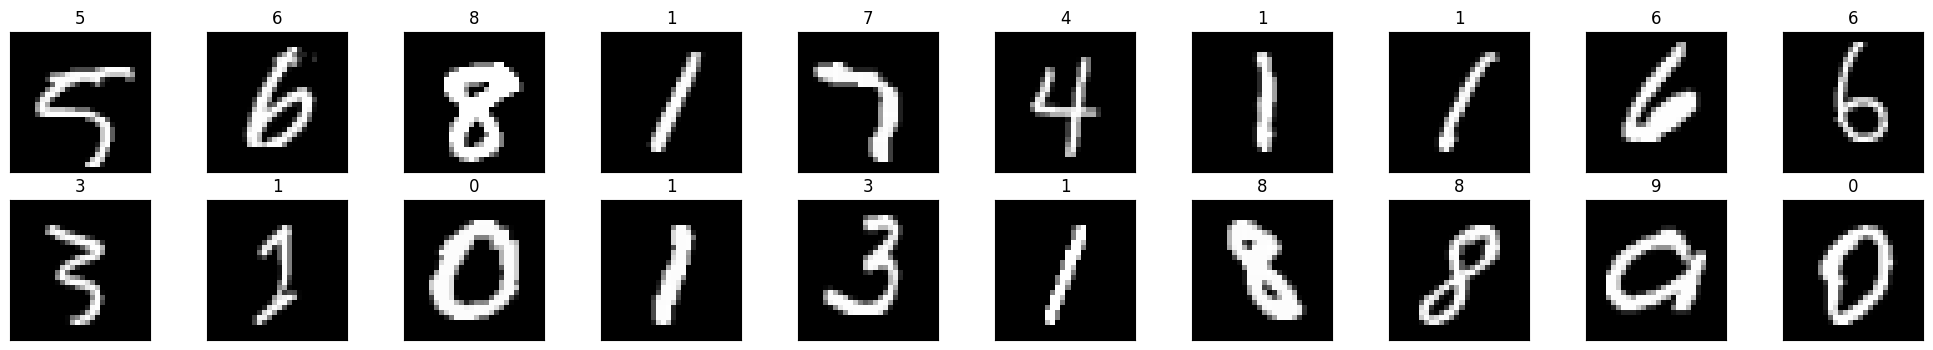

In [23]:
print("Some of the training samples and their labels : \n")

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))
print()

Pixel level View of one of the training sample 




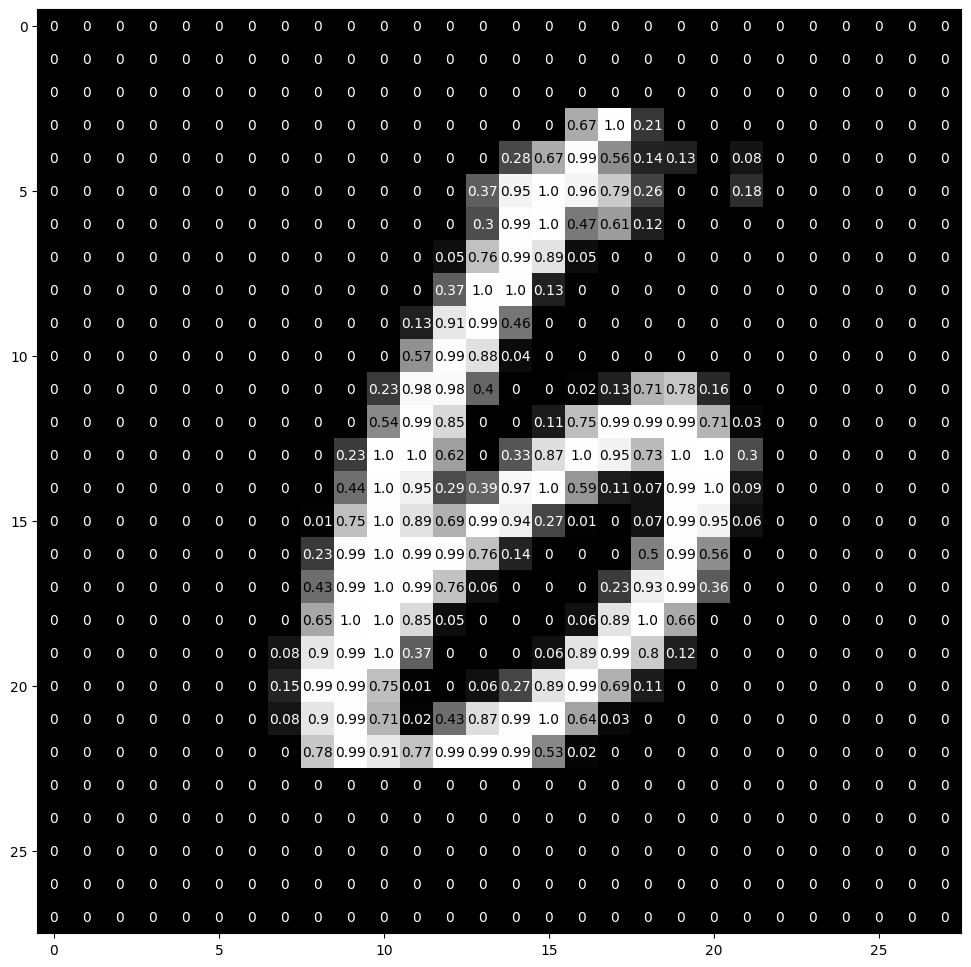

In [24]:
print ("Pixel level View of one of the training sample \n")
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
print()

In [25]:
## Define the NN architecture

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)       # linear layer (n_hidden -> n_hidden2)
        self.fc3 = nn.Linear(512, 10)        # linear layer (n_hidden2 -> 10)
        #self.dropout = nn.Dropout(0.2)       # dropout layer (p=0.2) # dropout prevents overfitting of data

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# initialize the NN
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


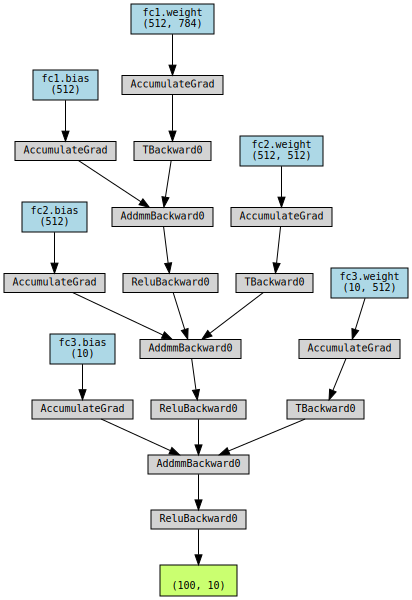

In [26]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
from torchviz import make_dot
img_grid=torchvision.utils.make_grid(images)
make_dot(model(images), params=dict(model.named_parameters()))

In [27]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss().to(device)

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

print(criterion, optimizer)

CrossEntropyLoss() SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [28]:
# number of epochs to train the model
n_epochs = 5  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):

    train_loss = 0.0                    #Initialize training, val loss
    val_loss=0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()            # clear the gradients of all optimized variables
        output = model(data)             # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # calculate the loss
        loss.backward()                  # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()                 # perform a single optimization step (parameter update)
        train_loss += loss.item()*data.size(0)  # update running training loss

    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)                  # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target)      # calculate the loss
        val_loss += loss.item()*data.size(0)  # update running training loss

    # print training statistics
    train_loss = train_loss/len(train_loader.dataset)  # calculate average loss over an epoch"""
    val_loss = val_loss/len(val_loader.dataset)        # Validation loss

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format( epoch+1, train_loss, val_loss ))
    print("Training is done\n")

Epoch: 1 	Training Loss: 1.319765 	Validation Loss: 0.851331
Training is done

Epoch: 2 	Training Loss: 0.621798 	Validation Loss: 0.560394
Training is done

Epoch: 3 	Training Loss: 0.519555 	Validation Loss: 0.504556
Training is done

Epoch: 4 	Training Loss: 0.474160 	Validation Loss: 0.466317
Training is done

Epoch: 5 	Training Loss: 0.441397 	Validation Loss: 0.439387
Training is done



In [29]:
# Testing the  model
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)                            # forward pass: compute predicted outputs by passing inputs to the model
    loss = criterion(output, target)                # calculate the loss
    test_loss += loss.item()*data.size(0)           # update test loss
    _, pred = torch.max(output, 1)                  # convert output probabilities to predicted class
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))        # compare predictions to true label

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print()

Test Loss: 0.429622

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1:  0% ( 0/1135)
Test Accuracy of     2: 95% (982/1032)
Test Accuracy of     3: 95% (968/1010)
Test Accuracy of     4: 95% (940/982)
Test Accuracy of     5: 92% (824/892)
Test Accuracy of     6: 96% (929/958)
Test Accuracy of     7: 92% (956/1028)
Test Accuracy of     8: 92% (905/974)
Test Accuracy of     9: 92% (932/1009)

Test Accuracy (Overall): 83% (8396/10000)



Test Images and their predicted labels : 



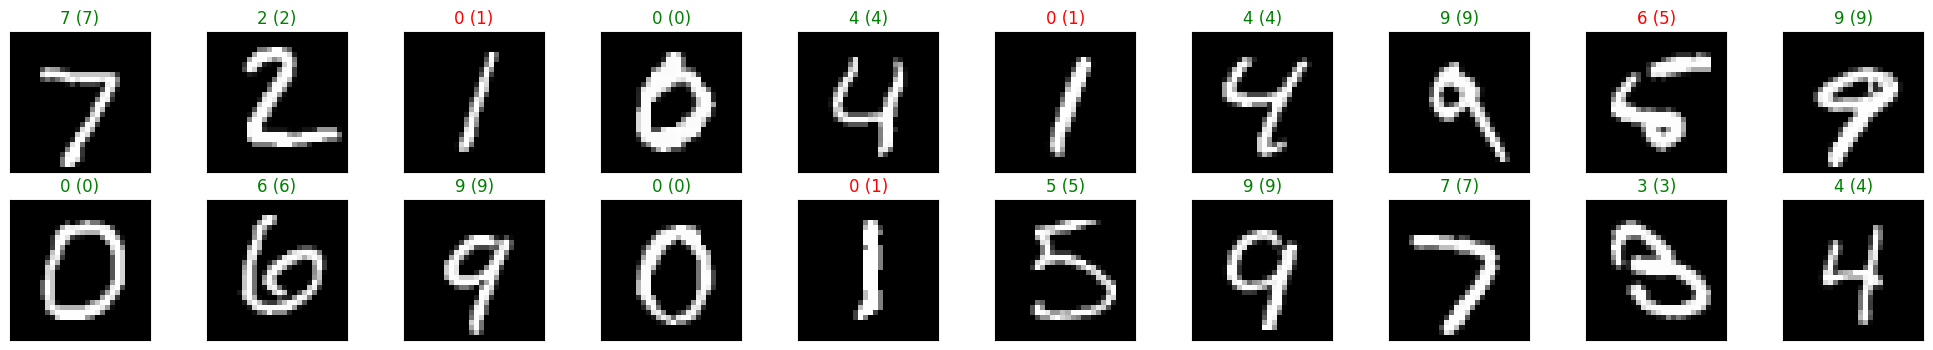

In [30]:
# obtain one batch of test images

print("Test Images and their predicted labels : \n")

dataiter = iter(test_loader)
images, labels = next(dataiter)
# get sample outputs
output = model(images.to(device))

_, preds = torch.max(output, 1)  # convert output probabilities to predicted class
images = images.numpy()         # prep images for display

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))